In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [19]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [20]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [21]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fullhour/fog_dataset_fulltime.hdf"
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6.hdf'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']
df_train['delta_theta'] = df_train['theta925'] - df_train['theta1000']
df_train['delta_theta_e'] = df_train['theta_e925'] - df_train['theta_e1000']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']
df_valid['delta_theta'] = df_valid['theta925'] - df_valid['theta1000']
df_valid['delta_theta_e'] = df_valid['theta_e925'] - df_valid['theta_e1000']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']
df_test['delta_theta'] = df_test['theta925'] - df_test['theta1000']
df_test['delta_theta_e'] = df_test['theta_e925'] - df_test['theta_e1000']

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour','delta_theta','delta_theta_e','theta_e925']
# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.fit_transform(valid_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]


['/test', '/train', '/valid']
(39856, 18)
(39856,)


In [22]:
print(df_train.columns)

Index(['visi', 'v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk',
       'vwnd1000', 'vwnd950', 'vwnd925', 'vwnd900', 'vwnd850', 'uwnd1000',
       'uwnd950', 'uwnd925', 'uwnd900', 'uwnd850', 'temp1000', 'temp950',
       'temp925', 'temp900', 'temp850', 'rhum1000', 'rhum950', 'rhum925',
       'rhum900', 'rhum850', 'theta_e1000', 'theta1000', 'theta_e950',
       'theta950', 'theta_e925', 'theta925', 'theta_e900', 'theta900',
       'theta_e850', 'theta850', 'actual_time', 'init_time', 'year', 'month',
       'day', 'hour', 'year_sin', 'year_cos', 'day_sin', 'day_cos',
       'station_vis', 'station_rain1', 'fc_hour', 'station_vis_cat',
       'station_vis_linear', 't_td', 'td_sst', 't_sst', 'delta_theta',
       'delta_theta_e'],
      dtype='object')


In [23]:
train_x[:,0:3]

array([[  0.83319092,  -0.46520996,   0.36798096],
       [  1.44522095,  -1.89187622,  -0.44665527],
       [  1.74514771,  -2.23706055,  -0.49191284],
       ...,
       [  8.95623779, -12.87210083,  -3.91586304],
       [  4.38320923,  -5.31814575,  -0.93493652],
       [  0.43878174,  -1.45422363,  -1.01544189]])

In [24]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Dense(60, activation='relu',
                       input_shape=train_x_scaled.shape[1:]),                 
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1),
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="mean_squared_error", optimizer="sgd")

In [25]:
train_x_scaled.shape[1:]

(18,)

In [26]:
model.layers

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 60)                1140      
                                                                 
 dense_4 (Dense)             (None, 8)                 488       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,637
Trainable params: 1,637
Non-trainable params: 0
_________________________________________________________________


In [28]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [41]:
# H:/github/python/seafog/
logdir = './callbacks_reg_fulltime'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_reg_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-4),
    ]
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/50
1246/1246 [==============================] - 3s 3ms/step - loss: 0.1400 - val_loss: 0.1567
Epoch 2/50
1246/1246 [==============================] - 3s 3ms/step - loss: 0.1395 - val_loss: 0.1673
Epoch 3/50
1246/1246 [==============================] - 3s 3ms/step - loss: 0.1388 - val_loss: 0.1683
Epoch 4/50
1246/1246 [==============================] - 4s 3ms/step - loss: 0.1388 - val_loss: 0.1565
Epoch 5/50
1246/1246 [==============================] - 4s 3ms/step - loss: 0.1378 - val_loss: 0.1662
Epoch 6/50
1246/1246 [==============================] - 3s 3ms/step - loss: 0.1375 - val_loss: 0.1596
Epoch 7/50
1246/1246 [==============================] - 3s 2ms/step - loss: 0.1367 - val_loss: 0.1535
Epoch 8/50
1246/1246 [==============================] - 3s 3ms/step - loss: 0.1363 - val_loss: 0.1575
Epoch 9/50
1246/1246 [==============================] - 3s 2ms/step - loss: 0.1358 - val_loss: 0.1600
Epoch 10/50
1246/1246 [==============================] - 3s 3ms/step - loss: 0.135

In [30]:
type(history)

keras.callbacks.History

In [31]:
history.history

{'loss': [0.27181410789489746,
  0.2162269502878189,
  0.20206484198570251,
  0.1925283521413803,
  0.18597984313964844,
  0.18091639876365662,
  0.17724815011024475,
  0.1739254891872406,
  0.17204549908638,
  0.1693294197320938,
  0.1668114811182022,
  0.16499128937721252,
  0.16240307688713074,
  0.16165101528167725,
  0.159617617726326,
  0.1589704155921936,
  0.15786832571029663,
  0.15606717765331268,
  0.15443389117717743,
  0.1540553867816925,
  0.1524885594844818,
  0.15154065191745758,
  0.15078327059745789,
  0.15022461116313934,
  0.14926572144031525,
  0.14775942265987396,
  0.14766249060630798,
  0.14648908376693726,
  0.14565707743167877,
  0.1451215296983719,
  0.14447982609272003,
  0.143423393368721,
  0.14311055839061737,
  0.14231562614440918,
  0.14159099757671356,
  0.1416659951210022,
  0.14043711125850677],
 'val_loss': [0.2325286567211151,
  0.2300790399312973,
  0.21362681686878204,
  0.24127879738807678,
  0.2152748852968216,
  0.20334592461585999,
  0.191374

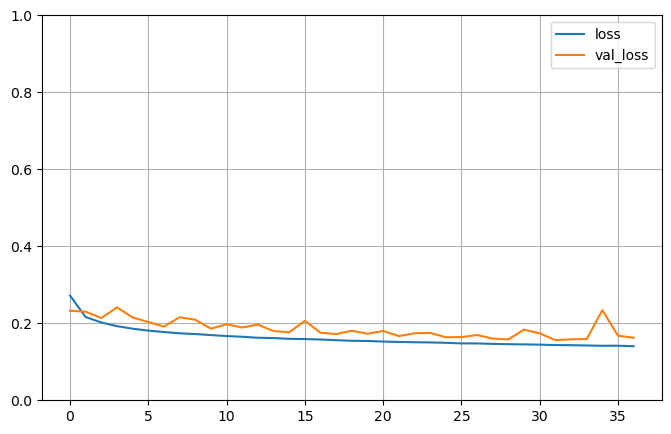

In [32]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [33]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.19846561551094055

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3

In [42]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.20271795988082886

In [43]:
predictions = model(test_x_scaled).numpy()
predictions

array([[0.79359186],
       [0.7252997 ],
       [0.80630237],
       ...,
       [2.8721466 ],
       [1.8074352 ],
       [2.4162679 ]], dtype=float32)

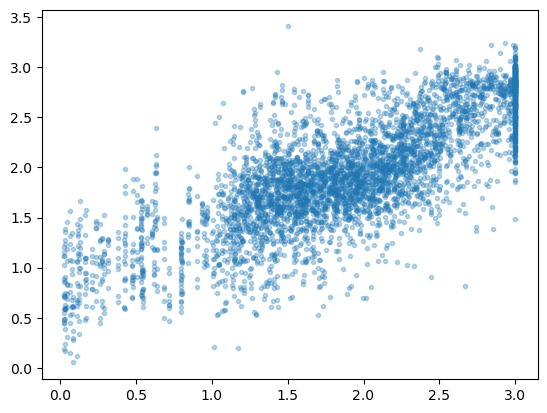

In [44]:
plt.plot(test_y, predictions,'.', alpha=0.3)
plt.show()

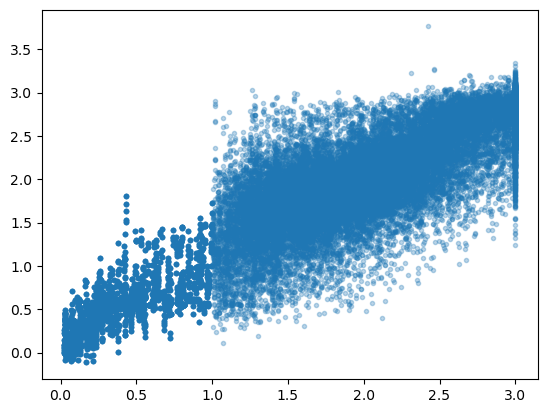

In [38]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

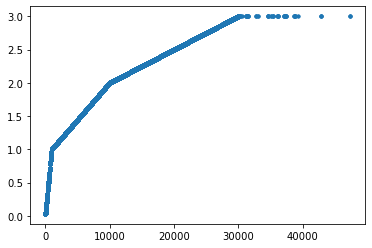

In [17]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

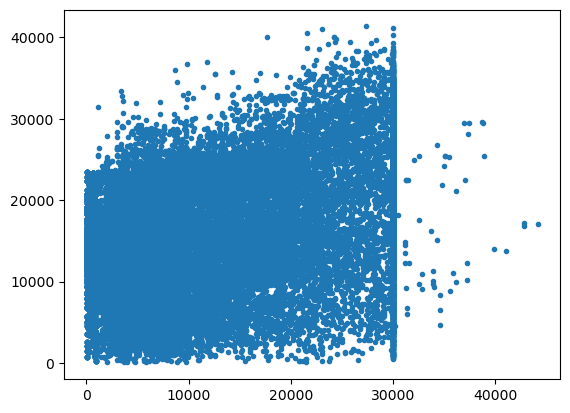

In [39]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

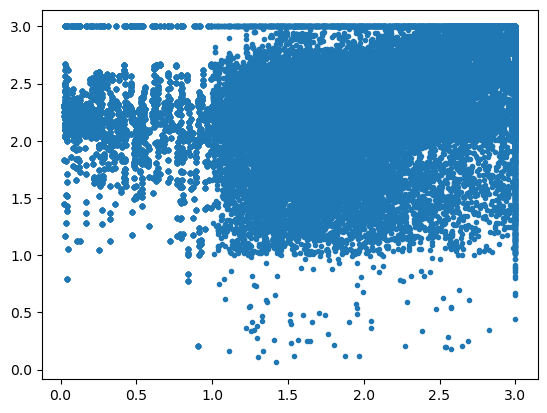

1.3624993631146236


In [40]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 